## Step 5: Collect hourly weather for LA (Q2 2025)

In [1]:
%pip install meteostat pytz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from meteostat import Hourly, Point
from datetime import datetime
import pandas as pd
import pytz
import os

os.makedirs("../data/external/weather", exist_ok=True)

In [4]:
# Downtown LA approx
la = Point(34.0522, -118.2437)

# Q2 2025 bounds
start = datetime(2025, 4, 1)
end   = datetime(2025, 6, 30, 23, 59)

tz = "America/Los_Angeles"

In [ ]:
# Peek at available columns first (helpful for debugging)
print("Available columns from Meteostat:", list(df_wx.columns))

# Friendly rename map (Meteostat keys -> our names)
rename_map = {
    "temp": "temp_c",          # °C
    "prcp": "precip_mm",       # mm
    "wspd": "wind_mps",        # m/s
    "wpgt": "gust_mps",        # m/s (may be missing)
    "pres": "pressure_hpa",    # hPa
    "rhum": "rel_humidity_pct",
    "coco": "weather_code"     # condition code
}

# Use only the columns that actually exist
available = [c for c in rename_map.keys() if c in df_wx.columns]

# Subset + rename
df_wx_tidy = df_wx[available].rename(columns=rename_map).reset_index().rename(columns={"time": "weather_time"})

# For a stable schema, ensure all expected outputs exist (fill missing with NaN)
expected_cols = ["weather_time","temp_c","precip_mm","wind_mps","gust_mps","pressure_hpa","rel_humidity_pct","weather_code"]
for col in expected_cols:
    if col not in df_wx_tidy.columns:
        df_wx_tidy[col] = pd.NA

# Reorder columns
df_wx_tidy = df_wx_tidy[expected_cols]

# Save
out_path = "../data/external/weather/la_hourly_2025_q2.csv"
df_wx_tidy.to_csv(out_path, index=False)
print("Saved:", out_path)
df_wx_tidy.head()

Available columns from Meteostat: ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
Saved: ../data/external/weather/la_hourly_2025_q2.csv


,weather_time,temp_c,precip_mm,wind_mps,gust_mps,pressure_hpa,rel_humidity_pct,weather_code
0,2025-04-01 00:00:00-07:00,12.0,0.0,22.7,<NA>,1016.4,85.0,3.0
1,2025-04-01 01:00:00-07:00,11.6,0.0,20.9,<NA>,1016.1,82.0,3.0
2,2025-04-01 02:00:00-07:00,11.5,0.0,21.2,<NA>,1015.6,80.0,3.0
3,2025-04-01 03:00:00-07:00,11.0,0.0,21.6,<NA>,1015.2,83.0,3.0
4,2025-04-01 04:00:00-07:00,10.5,0.0,21.6,<NA>,1014.9,82.0,1.0


In [7]:
# Load cleaned trips
trips = pd.read_csv("../data/processed/metro-trips-2025-q2_cleaned.csv", parse_dates=["start_dt", "end_dt"])

# Load hourly weather
weather = pd.read_csv("../data/external/weather/la_hourly_2025_q2.csv", parse_dates=["weather_time"])

In [11]:
# Make sure both are naive or both are tz-aware
weather["weather_time"] = weather["weather_time"].dt.tz_localize(None)

trips["trip_hour"] = trips["start_dt"].dt.floor("H")

# Merge
trips_wx = trips.merge(weather, left_on="trip_hour", right_on="weather_time", how="left")

print("Trips:", len(trips))
print("Merged trips with weather:", len(trips_wx))
trips_wx.head()


Trips: 123057
Merged trips with weather: 123057


,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,flag_same_station_low_dist,trip_hour,weather_time,temp_c,precip_mm,wind_mps,gust_mps,pressure_hpa,rel_humidity_pct,weather_code
0,497794246,1,4/1/2025 0:03,4/1/2025 0:04,4512,34.043812,-118.264969,4512,34.043812,-118.264969,...,True,2025-04-01,2025-04-01,12.0,0.0,22.7,NaN,1016.4,85.0,3.0
1,497794374,5,4/1/2025 0:06,4/1/2025 0:11,4512,34.043812,-118.264969,3005,34.048500,-118.258537,...,False,2025-04-01,2025-04-01,12.0,0.0,22.7,NaN,1016.4,85.0,3.0
2,497794444,6,4/1/2025 0:09,4/1/2025 0:15,4538,34.065430,-118.308823,4524,34.061630,-118.301193,...,False,2025-04-01,2025-04-01,12.0,0.0,22.7,NaN,1016.4,85.0,3.0
3,497794638,9,4/1/2025 0:20,4/1/2025 0:29,3005,34.048500,-118.258537,4315,34.054031,-118.270920,...,False,2025-04-01,2025-04-01,12.0,0.0,22.7,NaN,1016.4,85.0,3.0
4,497794649,7,4/1/2025 0:22,4/1/2025 0:29,3005,34.048500,-118.258537,3074,34.044170,-118.261169,...,False,2025-04-01,2025-04-01,12.0,0.0,22.7,NaN,1016.4,85.0,3.0


In [12]:
out_path = "../data/processed/metro-trips-2025-q2_with_weather.csv"
trips_wx.to_csv(out_path, index=False)
print("Saved merged trips-weather file to:", out_path)

Saved merged trips-weather file to: ../data/processed/metro-trips-2025-q2_with_weather.csv


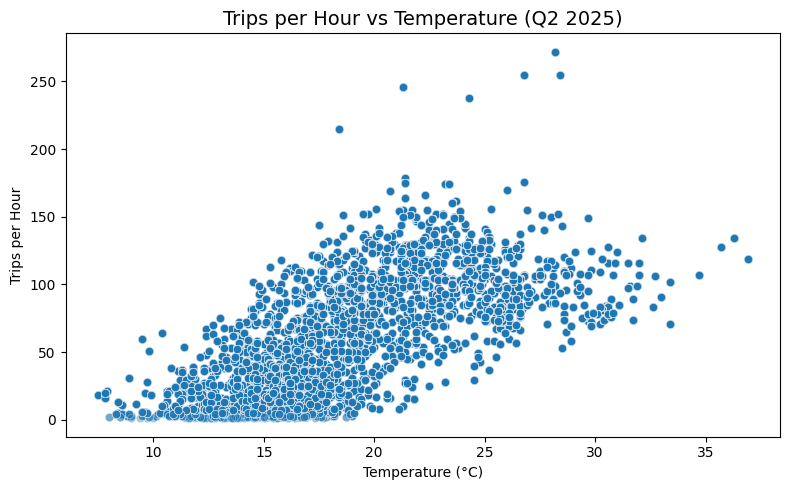

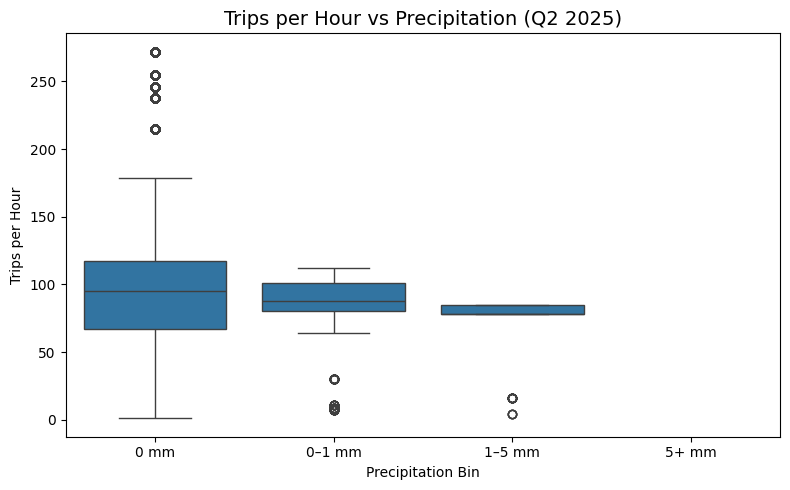

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("../visuals/plots", exist_ok=True)

# Trips vs temperature
plt.figure(figsize=(8,5))
sns.scatterplot(data=trips_wx, x="temp_c", y=trips_wx.groupby("trip_hour")["trip_id"].transform("count"), alpha=0.4)
plt.title("Trips per Hour vs Temperature (Q2 2025)", fontsize=14)
plt.xlabel("Temperature (°C)")
plt.ylabel("Trips per Hour")
plt.tight_layout()
plt.savefig("../visuals/plots/trips_vs_temp_q2_2025.png", dpi=300)
plt.show()

# Trips vs precipitation
plt.figure(figsize=(8,5))
sns.boxplot(data=trips_wx, x=pd.cut(trips_wx["precip_mm"], bins=[-0.1, 0.0, 1.0, 5.0, 20.0], labels=["0 mm","0–1 mm","1–5 mm","5+ mm"]),
            y=trips_wx.groupby("trip_hour")["trip_id"].transform("count"))
plt.title("Trips per Hour vs Precipitation (Q2 2025)", fontsize=14)
plt.xlabel("Precipitation Bin")
plt.ylabel("Trips per Hour")
plt.tight_layout()
plt.savefig("../visuals/plots/trips_vs_precip_q2_2025.png", dpi=300)
plt.show()
